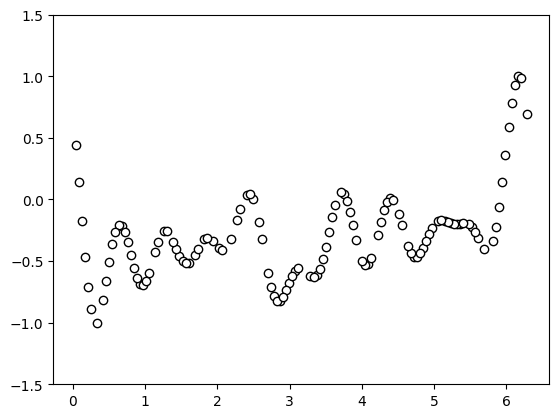

In [19]:
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as np
import optax
import jax
import jax.numpy as jnp
import pickle
from sklearn.model_selection import train_test_split

# from models.pennylane_models import *
from models.controlled_rotations import *
from models.cnot_models import *
from models.ising_coupling import *

coeffs = [
    (1.29 + 1.13j),  # c_1
    (0.43 + 0.89j),  # c_2
    (1.97 + 1.03j),  # c_3
    (0.17 + 0.59j),  # c_4
    (1.71 + 1.41j),  # c_5
    (0.61 + 0.37j),  # c_6
    (1.19 + 1.67j),  # c_7
    (0.73 + 1.61j),  # c_8
    (0.23 + 0.47j),  # c_9
    (1.83 + 0.83j),  # c_10
]

c0 = 0.0
scaling = 1
degree = len(coeffs)

def key_generator(seed):
    key = jax.random.PRNGKey(seed)
    while True:
        key, subkey = jax.random.split(key)
        yield subkey

def target_function(x):
    res = c0
    for idx, c in enumerate(coeffs):
        exponent = scaling * (idx + 1) * x * 1j
        conj_c = jnp.conjugate(c)
        res += c * jnp.exp(exponent) + conj_c * jnp.exp(-exponent)
    return jnp.real(res)

def minmax_scaler(y):
    # Scale y to [0, 1]
    y_min = jnp.min(y)
    y_max = jnp.max(y)
    y_scaled = (y - y_min) / (y_max - y_min)
    return y_scaled

def scaled_data(n_points):
    x_raw = jnp.linspace(-12, 12, n_points)
    x = minmax_scaler(x_raw) * 2 * jnp.pi
    target_y = jax.vmap(target_function)(x)
    target_y_scaled = minmax_scaler(target_y) * 2 - 1
    return x, target_y_scaled


x_raw = jnp.linspace(-12, 12, 150)
x = minmax_scaler(x_raw) * 2 * jnp.pi
target_y = jax.vmap(target_function)(x)
target = minmax_scaler(target_y) * 2 - 1

x_train, x_test, y_train, y_test = train_test_split(x, target, test_size=0.2, random_state=16)

# plt.plot(x_train, y_train)
plt.scatter(x_train, y_train, facecolor="white", edgecolor="black")
plt.ylim(-1.5, 1.5)
plt.show()

In [22]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime.fake_provider import FakeProvider

# Clear any existing accounts
try:
    QiskitRuntimeService.delete_account()
except:
    pass

token = ""
crn = ""

service = QiskitRuntimeService.save_account(token=token, instance=crn, set_as_default=True, overwrite=True)

# Test connection
service = QiskitRuntimeService()
print("Connection successful!")
print("Available backends:", [b.name for b in service.backends()])

backend = FakeProvider()

# Check if it's currently available
print(f"Operational: {backend.status().operational}")
print(f"Pending jobs: {backend.status().pending_jobs}")

# Get qubit properties
print(f"Number of qubits: {backend.num_qubits}")
device = qml.device(
    'qiskit.remote',
    wires=10,
    backend=backend,  # ⚠️ Must be backend object, not string!
    shots=1024,  # More shots = better statistics
    optimization_level=3,  # Higher optimization (0-3)
    resilience_level=2,  # Error mitigation level (0-2)
    seed_transpiler=42,  # Reproducible transpilation
    # Additional runtime options:
    #dynamical_decoupling={'enable': True},  # Dynamical decoupling
    #twirling={'enable_gates': True},         # Gate twirling
    # Additional transpiler options:
    #routing_method='sabre',             # Routing algorithm
    #layout_method='sabre',              # Initial layout method
    #translation_method='translator',    # Gate translation method
)

Connection successful!
Available backends: ['ibm_brisbane', 'ibm_fez', 'ibm_torino', 'ibm_pittsburgh', 'ibm_marrakesh', 'ibm_kingston']


AttributeError: 'FakeProviderForBackendV2' object has no attribute 'status'

In [ ]:
keys = key_generator(16)
group_name = "standard"
qm, weights, name = basic_ry_crx_rz(device, univariate_parallel_encoding, 10, 3, 1, next(keys))

def square_loss(targets, predictions):
    return 0.5 * jnp.mean((targets - predictions) ** 2)

def cost(weights, model, x, y):
    predictions = model(x, weights)
    return square_loss(y, predictions)

def r2_score(y_true, y_pred):
    ss_resid = jnp.sum((y_true - y_pred) ** 2)
    ss_total = jnp.sum((y_true - jnp.mean(y_true)) ** 2)
    return 1 - ss_resid / ss_total

def param_count(pytree):
    leaves = jax.tree_util.tree_leaves(pytree)
    return int(sum(jnp.size(leaf) for leaf in leaves))

predictions_r2scores_models = []
costs = []
trained_weights = []

opt = qml.AdamOptimizer(0.1)

max_steps = 5000
batch_size = 1
num_params = param_count(weights)
cst = [cost(weights, qm, x, target_y)]  # initial cost

for step in range(max_steps):

    batch_index = jax.random.choice(next(keys), len(x_train), (batch_size,), replace=False)

    x_batch = x_train[batch_index]
    y_batch = y_train[batch_index]

    weights, _, _ = opt.step(cost, weights, x_batch, y_batch)

    c = cost(weights, qm, x_train, y_train)
    cst.append(c)

    if (step + 1) % 1000 == 0:
        print("Cost at step {0:3} for {1} params: {2}".format(step + 1, num_params, c))

# after a model is trained, everything gets saved in a list
costs.append((cst, name, num_params))
trained_weights.append((weights, name, num_params))

predictions = qm(x_train, weights)
r2 = r2_score(y_train, predictions)
print(r2)
predictions_r2scores_models.append((predictions, r2, name, num_params))
with open(f"ibm_fake/predictions_r2scores_{group_name}_{name}_degree{degree}_{num_params}params", "wb") as f:
    pickle.dump(predictions_r2scores_models, f)
with open(f"ibm_fake/costs_{group_name}_{name}_degree{degree}_{num_params}params", "wb") as f:
    pickle.dump(costs, f)
with open(f"ibm_fake/trained_weights_{group_name}_{name}_degree{degree}_{num_params}params", "wb") as f:
    pickle.dump(trained_weights, f)

plt.scatter(x_train, predictions, facecolor="white", edgecolor="black", label=f"{name}_{num_params}: R² = {r2:.4f}")
plt.plot(x, target, c="black")
# plt.scatter(x, target_y, facecolor="white", edgecolor="black")
plt.ylim(-1.1, 1.1)
plt.legend()
plt.savefig(f"ibm_fake/fit_r2_{group_name}_{name}_degree{degree}_{num_params}params.png")
plt.show()